In [1]:
from utils import (
    get_areas, 
    get_specimen_ids, 
    get_trials,
    get_units_count,
    get_summary_df,
    load_memmap,
    load_index
)

from neural_maps import (
    sim_corrected_source_pair, 
    pls_corrected_single_source_to_B,
    sim_corrected_model_to_B,
    pls_corrected_model_to_B
)

from mapping import (
    compute_all_layer_scores,
    compute_area_scores
)

from alex_extractor import build_alexnet_design_matrices_with_dataloader, AlexNetFeatureExtractor

from plotter import plot_comparison, plot_delta_vs_baseline

import itertools
import pandas as pd
import json
import os

from itertools import product
from pathlib import Path
import pickle
from tqdm import tqdm

# Signals

## Model (Alexnet)

Producing the Alexnet activations for all the stimuli of the Allen dataset, for all the trained model and the untrained one

In [2]:
# # Common params once
# COMMON = dict(
#     folder="../PreprocData/stimuli_images/",
#     batch_size=16,
#     shuffle=False,
#     num_workers=4,
#     device="cpu",
#     amp=True,
#     layers_keep=["conv1","conv2","conv3","conv4","conv5"],
#     return_in_memory=False,  # keeps memmaps on disk (good for many models)
# )

# # Built-ins
# weight_specs = [
#     ("Random",   "random"),
#     ("ImageNet", "imagenet"),
# ]

# # # Add all local .pth/.pt in a directory (adjust path!)
# ckpt_dir = Path("../model-weights/")  # e.g., Path("../checkpoints")
# for p in sorted(ckpt_dir.glob("*.pth")) + sorted(ckpt_dir.glob("*.pt")):
#     label = p.stem  # nice display name
#     # You can pass a str path because of the patch above:
#     weight_specs.append((label, str(p)))

# diet_opts = ["diet", "no-diet", "random-diet", "nayebi-diet"] # diet options at inference time 

# def make_save_dir(label: str, diet: bool) -> str:
#     base = f"{label.lower().replace(' ', '-')}"
#     return f"{base}-{diet}-act" 

# index_models = {}
# for (label, weights), diet in product(weight_specs, diet_opts):
#     tag = f"{label}-{diet}"
#     save_dir = make_save_dir(label, diet)
#     index_models[tag] = build_alexnet_design_matrices_with_dataloader(
#         **COMMON,
#         weights=weights,  # "random" | "imagenet" | "/path/to.ckpt" (string) | {"file": "..."}
#         diet=diet,
#         save_dir=save_dir,
#     )


## Loading Neural Data

In [3]:
# # load the index containing the neural data
# index_df = pd.read_csv('../PreprocData/PreprocData/index.csv')

# RSA

In [4]:
# from tqdm import tqdm

# layer_scores_rsa = {}
# median_scores_rsa = {}

# # Wrap the loop with tqdm
# for name, idx in tqdm(index_models.items(), desc="Computing area scores", total=len(index_models)):
#     layers, median = compute_area_scores(idx, index_df, sim_metric="RSA")
#     layer_scores_rsa[name] = layers
#     median_scores_rsa[name] = median

In [5]:
# with open("rsa_results.pkl", "wb") as f:
#     pickle.dump({
#         "layer_scores": layer_scores_rsa,
#         "median_scores": median_scores_rsa
#     }, f)

In [6]:
# load the pkl dictionaries with results

with open("rsa_results.pkl", "rb") as f:
    results = pickle.load(f)

layer_scores_rsa = results["layer_scores"]
median_scores_rsa = results["median_scores"]

/home/spina/Desktop/units/DL/project/rep-analysis/representation/plotter.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(layer_order, rotation=0)
/home/spina/Desktop/units/DL/project/rep-analysis/representation/plotter.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(layer_order, rotation=0)
/home/spina/Desktop/units/DL/project/rep-analysis/representation/plotter.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(layer_order, rotation=0)


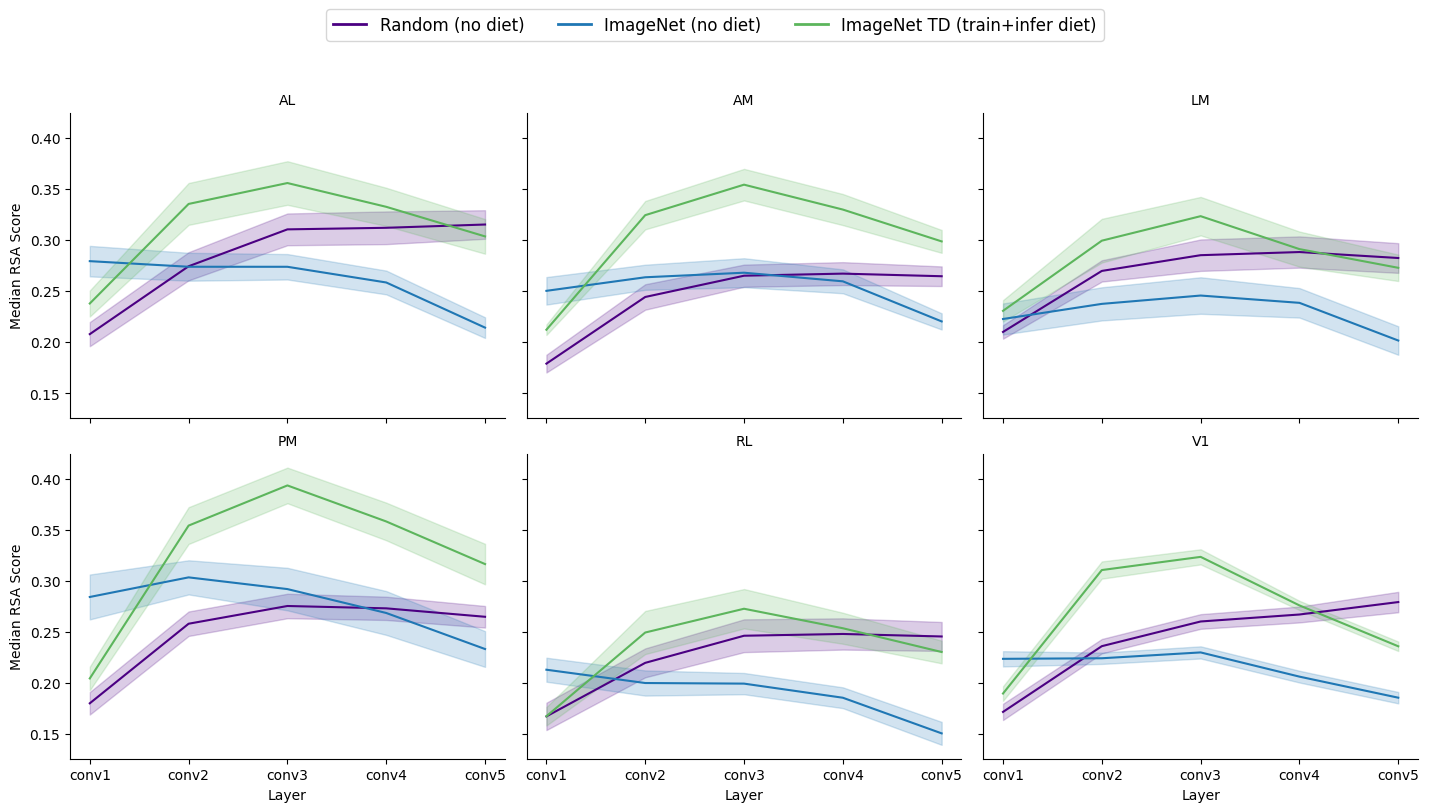

In [7]:
scores_to_plot_rsa = {
    "Rand-In" : median_scores_rsa["Random-no-diet"],
    # "Rand-Id" : median_scores_rsa["Random-diet"],
    # "Rand-Ir" : median_scores_rsa["Random-random-diet"],
    # "Rand-Iny" : median_scores_rsa["Random-nayebi-diet"],

    "INet-In" : median_scores_rsa["ImageNet-no-diet"],
    # "INet-Id" : median_scores_rsa["ImageNet-diet"],
    # "INet-Ir" : median_scores_rsa["ImageNet-random-diet"],
    # "INet-Iny" : median_scores_rsa["ImageNet-nayebi-diet"],

    # "INet-Td-In" : median_scores_rsa["inet-td-no-diet"],
    "INet-Td-Id" : median_scores_rsa["inet-td-diet"],
    # "INet-Td-Ir" : median_scores_rsa["inet-td-random-diet"],
    # "INet-Td-Iny" : median_scores_rsa["inet-td-nayebi-diet"],

    # "FT-In" : median_scores_rsa["finetune-no-diet"],
    # "FT-Id" : median_scores_rsa["finetune-diet"],
    # "FT-Ir" : median_scores_rsa["finetune-random-diet"],
    # "FT-Iny" : median_scores_rsa["finetune-nayebi-diet"],
}

plot_comparison(scores_to_plot_rsa, metric_name="RSA")


In [8]:
import pandas as pd

# fattori di normalizzazione per area
area_norm = pd.Series({
    "AL": 0.651665,
    "AM": 0.604958,
    "LM": 0.475808,
    "PM": 0.580446,
    "RL": 0.5,
    "V1": 0.624521,
}, name="norm_factor")

def normalize_scores_by_area(scores_dict, *, normalize_sem=True):
    """scores_dict: dict[str, pd.DataFrame] con colonne ['area','layer','score','sem']"""
    out = {}
    for model_name, df in scores_dict.items():
        df2 = df.copy()
        # aggiunge il fattore per area
        df2 = df2.merge(area_norm, left_on="area", right_index=True, how="left")
        if df2["norm_factor"].isna().any():
            missing = df2.loc[df2["norm_factor"].isna(), "area"].unique().tolist()
            raise ValueError(f"Manca il fattore per queste aree: {missing}")
        # normalizza
        df2["score"] = df2["score"] / df2["norm_factor"]
        if normalize_sem and "sem" in df2.columns:
            df2["sem"] = df2["sem"] / df2["norm_factor"]
        # pulizia
        df2 = df2.drop(columns=["norm_factor"])
        out[model_name] = df2
    return out

# usa la funzione sul tuo dizionario
scores_to_plot_rsa_norm = normalize_scores_by_area(scores_to_plot_rsa, normalize_sem=True)

# poi plotta come sempre
# plot_comparison(scores_to_plot_rsa_norm, metric_name="RSA (normalized)")


In [9]:
scores_to_plot_rsa = {
    "Rand-In" : median_scores_rsa["Random-no-diet"],
    "INet-In" : median_scores_rsa["ImageNet-no-diet"],
    # "INet-Id" : median_scores_rsa["ImageNet-diet"],
    # "INet-Iny" : median_scores_rsa["ImageNet-nayebi-diet"],
    "INet-Td-Id" : median_scores_rsa["inet-td-diet"],
    # "FT-Id" : median_scores_rsa["finetune-diet"],
}

scores_to_plot_rsa_norm = normalize_scores_by_area(scores_to_plot_rsa, normalize_sem=True)

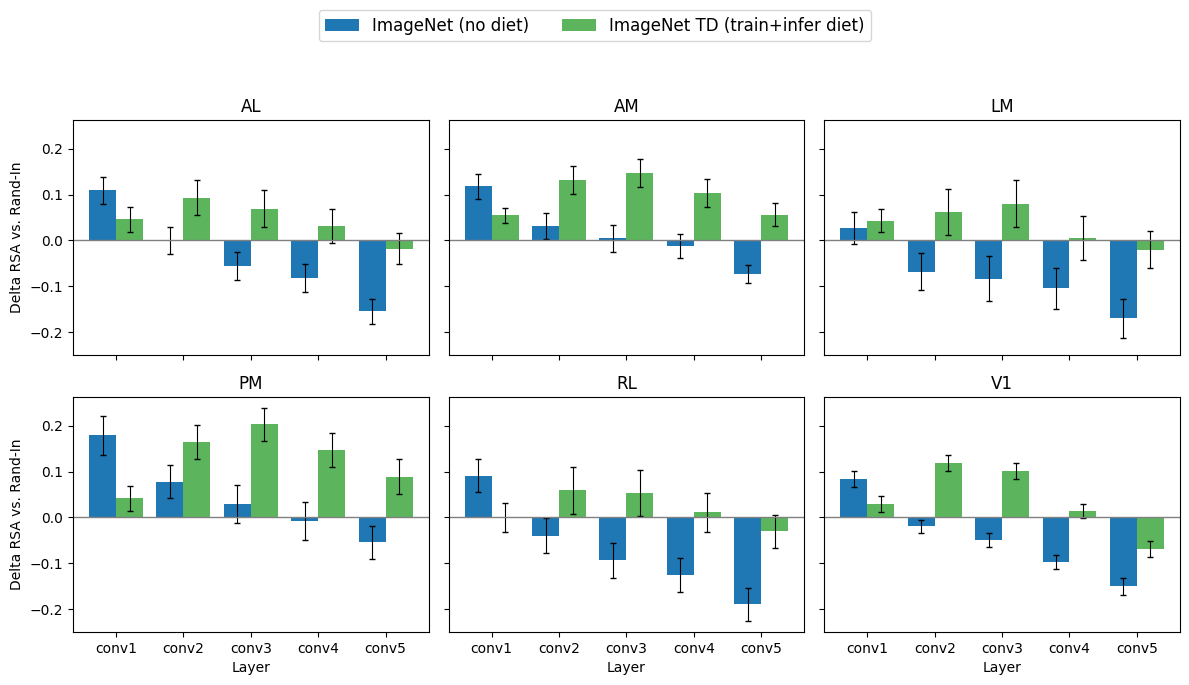

In [10]:
plot_delta_vs_baseline(scores_to_plot_rsa_norm)

## Diet impact over Random

In [11]:
scores_to_plot_rsa = {
    "Rand-In" : median_scores_rsa["Random-no-diet"],
    "Rand-Id" : median_scores_rsa["Random-diet"],
    "Rand-Iny" : median_scores_rsa["Random-nayebi-diet"],
    "Rand-Ir" : median_scores_rsa["Random-random-diet"],
}

scores_to_plot_rsa_norm = normalize_scores_by_area(scores_to_plot_rsa, normalize_sem=True)

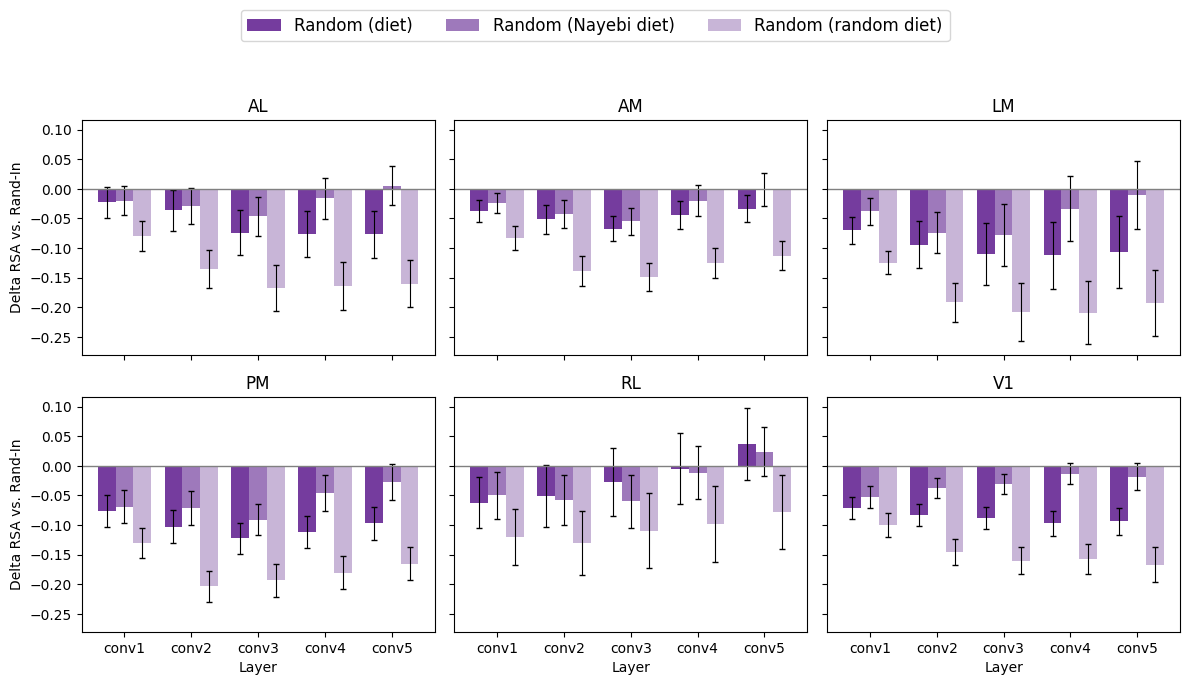

In [12]:
plot_delta_vs_baseline(scores_to_plot_rsa_norm)

### RSA heatmaps

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_median_score_heatmap(
    scores_dict,
    model_key=None,
    metric_name="CKA",
    area_order=None,
    layer_order=None,
    annot_fmt=".3f",
    vmin=0,
    vmax=1.0
):
    """
    Plot a heatmap of median scores (CKA or RSA) for a given model key.
    
    Parameters
    ----------
    scores_dict : dict
        Dictionary mapping model keys to DataFrames with columns ['area','layer','score','sem'].
        e.g. median_scores_cka or median_scores_rsa
    model_key : str, optional
        Key of the model to plot. Defaults to the first available key in `scores_dict`.
    metric_name : str, optional
        Name of the metric for labeling (e.g., "CKA" or "RSA").
    area_order : list of str, optional
        Order of visual areas.
    layer_order : list of str, optional
        Order of model layers.
    annot_fmt : str, optional
        Format of annotation numbers (default ".3f").
    vmin, vmax : float, optional
        Fixed color scale limits for the heatmap.
    """
    
    # Se non specificato, usa la prima chiave disponibile
    if model_key is None:
        model_key = list(scores_dict.keys())[0]
    if model_key not in scores_dict:
        raise KeyError(f"Model key {model_key!r} not found in scores_dict")

    df = scores_dict[model_key][['area', 'layer', 'score']].copy()

    if layer_order is None:
        layer_order = ["conv1", "conv2", "conv3", "conv4", "conv5"]
    if area_order is None:
        area_order = ["AL", "AM", "LM", "PM", "RL", "V1"]

    pivot = df.pivot(index="area", columns="layer", values="score")
    pivot = pivot.reindex(index=area_order, columns=layer_order)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=annot_fmt,
        cmap="viridis",
        cbar_kws={"label": f"median {metric_name} score"},
        vmin=vmin,
        vmax=vmax
    )
    plt.title(f"Median {metric_name} — {model_key}")
    plt.xlabel("Conv Layer")
    plt.ylabel("Visual Area")
    plt.tight_layout()
    return plt.gca()


In [14]:
plot_median_score_heatmap(scores_to_plot_rsa_norm, model_key="FT-Id", metric_name="RSA", vmax=0.8)
plt.show()

KeyError: "Model key 'FT-Id' not found in scores_dict"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def _plot_single_heatmap_from_df(df, ax, title, area_order, layer_order, annot_fmt, vmin, vmax, metric_name):
    if df is None:
        ax.axis("off")
        ax.text(0.5, 0.5, "missing", ha="center", va="center", fontsize=12)
        ax.set_title(title)
        return

    pivot = df[['area', 'layer', 'score']].pivot(index="area", columns="layer", values="score")
    # reindex to consistent order (allow missing rows/cols)
    pivot = pivot.reindex(index=area_order, columns=layer_order)

    sns.heatmap(
        pivot,
        ax=ax,
        annot=True,
        fmt=annot_fmt,
        cmap="viridis",
        cbar_kws={"label": f"median {metric_name} score"},
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(title)
    ax.set_xlabel("Conv Layer")
    ax.set_ylabel("Visual Area")


def plot_metric_grids_by_family(
    scores_dict,
    metric_name="RSA",
    families=None,
    area_order=None,
    layer_order=None,
    annot_fmt=".3f",
    vmin=0.0,
    vmax=0.5,
    figsize=(10, 8),
    tight=True
):
    """
    Crea una figura per ciascuna famiglia (es. Rand, INet, INet-Td, FT),
    con una griglia 2x2 che mostra i 4 casi: -In, -Id, -Ir, -Iny.

    Parameters
    ----------
    scores_dict : dict[str -> DataFrame]
        Dizionario che mappa le chiavi modello ai rispettivi DataFrame
        con colonne ['area','layer','score','sem'].
    metric_name : str
        Nome metrica per label della colorbar (es. "RSA" o "CKA").
    families : dict[str -> list[str]]
        Mappa {nome_famiglia: [chiavi_quadranti]} in ordine:
        [[0,0]=In, [0,1]=Id, [1,0]=Ir, [1,1]=Iny].
        Se None, usa una mappa di default per Rand/INet/INet-Td/FT.
    area_order, layer_order : list[str]
        Ordine di aree e layer.
    annot_fmt : str
        Formato annotazioni heatmap.
    vmin, vmax : float
        Limiti fissi della scala colore.
    figsize : tuple
        Dimensione delle figure per ogni famiglia.
    tight : bool
        Se True, usa tight_layout.
    """

    if layer_order is None:
        layer_order = ["conv1", "conv2", "conv3", "conv4", "conv5"]
    if area_order is None:
        area_order = ["AL", "AM", "LM", "PM", "RL", "V1"]

    # mappa di default per le famiglie richieste
    if families is None:
        families = {
            "Rand":    ["Rand-In", "Rand-Id", "Rand-Ir", "Rand-Iny"],
            "INet":    ["INet-In", "INet-Id", "INet-Ir", "INet-Iny"],
            "INet-Td": ["INet-Td-In", "INet-Td-Id", "INet-Td-Ir", "INet-Td-Iny"],
            "FT":      ["FT-In", "FT-Id", "FT-Ir", "FT-Iny"],
        }

    figures = {}
    for fam_name, keys in families.items():
        # garantisco 4 posizioni (In, Id, Ir, Iny)
        keys = (keys + [None] * 4)[:4]

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.reshape(2, 2)

        # mappa posizioni:  (row, col): idx
        positions = [(0,0), (0,1), (1,0), (1,1)]

        for idx, (r, c) in enumerate(positions):
            key = keys[idx]
            title = f"{fam_name}: " + ["In","Id","Ir","Iny"][idx]
            df = scores_dict.get(key, None) if key is not None else None
            _plot_single_heatmap_from_df(
                df=df,
                ax=axes[r, c],
                title=title,
                area_order=area_order,
                layer_order=layer_order,
                annot_fmt=annot_fmt,
                vmin=vmin,
                vmax=vmax,
                metric_name=metric_name
            )

        if tight:
            plt.tight_layout()
        figures[fam_name] = (fig, axes)

    return figures


In [ ]:
figs = plot_metric_grids_by_family(
    scores_to_plot_rsa_norm,
    metric_name="RSA",
    vmin=0.0, vmax=0.8  # scala fissa
)


# CKA

In [ ]:
layer_scores_cka = {}
median_scores_cka = {}

# Wrap the loop with tqdm
for name, idx in tqdm(index_models.items(), desc="Computing area scores", total=len(index_models)):
    layers, median = compute_area_scores(idx, index_df, sim_metric="CKA")
    layer_scores_cka[name] = layers
    median_scores_cka[name] = median

with open("cka_results.pkl", "wb") as f:
    pickle.dump({
        "layer_scores": layer_scores_cka,
        "median_scores": median_scores_cka
    }, f)

In [ ]:
# # # load the pkl dictionaries with results
with open("cka_results.pkl", "rb") as f:
    results = pickle.load(f)

layer_scores_cka = results["layer_scores"]
median_scores_cka = results["median_scores"]

In [ ]:
scores_to_plot_cka = {
    "Rand-In" : median_scores_cka["Random-no-diet"],
    # "Rand-Id" : median_scores_cka["Random-diet"],
    # "Rand-Ir" : median_scores_cka["Random-random-diet"],
    # "Rand-Iny" : median_scores_cka["Random-nayebi-diet"],


    "INet-In" : median_scores_cka["ImageNet-no-diet"],
    # "INet-Id" : median_scores_cka["ImageNet-diet"],
    # "INet-Ir" : median_scores_cka["ImageNet-random-diet"],
    # "INet-Iny" : median_scores_cka["ImageNet-nayebi-diet"],

    # "INet-Td-In" : median_scores_cka["inet-td-no-diet"],
    "INet-Td-Id" : median_scores_cka["inet-td-diet"],
    # "INet-Td-Ir" : median_scores_cka["inet-td-random-diet"],
    # "INet-Td-Iny" : median_scores_cka["inet-td-nayebi-diet"],

    # "FT-In" : median_scores_cka["finetune-no-diet"],
    "FT-Id" : median_scores_cka["finetune-diet"],
    # "FT-Ir" : median_scores_cka["finetune-random-diet"],
    # "FT-Iny" : median_scores_cka["finetune-nayebi-diet"],
}

plot_comparison(scores_to_plot_cka, metric_name="CKA")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_median_cka_heatmap(model_key=None, area_order=None, layer_order=None, annot_fmt=".3f"):
    """
    Plot a heatmap of median CKA scores for a given model key from `median_scores_cka`.
    Uses median_scores_cka[model_key] DataFrame with columns ['area','layer','score','sem'].
    """
    if model_key is None:
        # default to first available key
        model_key = list(median_scores_cka.keys())[0]
    if model_key not in median_scores_cka:
        raise KeyError(f"Model key {model_key!r} not found in median_scores_cka")

    df = median_scores_cka[model_key][['area', 'layer', 'score']].copy()

    if layer_order is None:
        layer_order = ["conv1", "conv2", "conv3", "conv4", "conv5"]
    if area_order is None:
        # sensible default ordering of visual areas
        area_order = ["AL", "AM", "LM", "PM", "RL", "V1"]

    pivot = df.pivot(index="area", columns="layer", values="score")
    pivot = pivot.reindex(index=area_order, columns=layer_order)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=annot_fmt,
        cmap="viridis",
        cbar_kws={"label": "median CKA score"},
        vmin=0,       # scala minima
        vmax=0.35      # scala massima
    )
    plt.title(f"Median CKA — {model_key}")
    plt.xlabel("Conv Layer")
    plt.ylabel("Visual Area")
    plt.tight_layout()
    return plt.gca()


In [ ]:
for key in median_scores_cka.keys():
    plot_median_cka_heatmap(key)
    plt.show()